In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import matplotlib.pyplot as plt
import re
from sklearn.decomposition import PCA
from numpy import linalg as LA
from scipy.spatial import distance
from scipy.linalg import subspace_angles
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

In [2]:
net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model
import tools
from tools_lnd import plot_N, plot_FP, gen_trials_from_model_dir, name_best_ckpt, gen_X_from_model_dir_epoch

In [3]:
rule_set = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

rule_set_names = ['DelayGo', 'ReactGo', 'MemoryGo', 'DelayAnti', 'ReactAnti', 'MemoryAnti',
              'Decison1', 'Decison2', 'ContextDecison1', 'ContextDecison2', 'MultiDecison',
              'DelayDecison1', 'DelayDecison2', 'ContextDelayDecison1', 'ContextDelayDecison2', 'MultiDelayDecison',
              'DelayMatch2SampleGo', 'DelayMatch2SampleNogo', 'DelayMatch2CategoryGo', 'DelayMatch2CategoryNoGo']

In [6]:
h_context_combined = []
h_stim_early_combined = []
h_stim_late_combined = []
n_tasks = len(tasks)
trial_set = np.concatenate((range(1,400,50),range(0,400,50))) #range(0,400)

for model_n in range(1):
    
    dir_specific = 'no_reg'
    model_dir_all = os.path.join(p,'data/rnn/multitask/crystals/softplus/',dir_specific,str(model_n))
    model = Model(model_dir_all)
    with tf.Session() as sess:

        ckpt_n = name_best_ckpt(model_dir_all,'delaygo')
        ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))
        model.saver.restore(sess,ckpt_n_dir)
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]
        # get hparams
        hparams = model.hp
        trial = generate_trials('delaygo', hparams, mode='test', noise_on=False, delay_fac =1)
        
        #get size of relevant variables to init mats
        n_inputs = np.shape(trial.x)[2]
        N = np.shape(params[0])[1]
        #change this depending on when in the trial you're looking [must be a transition btwn epochs]
        time_set = [trial.epochs['stim1'][0]] #range(len([trial.epochs['stim1'][0]]))#

        #init mats
        J_np_u = np.zeros((n_tasks,len(trial_set),len(time_set),N,n_inputs))
        J_np_u_dot_delu = np.zeros((n_tasks,len(trial_set),len(time_set),N))
        #             J_np_x = np.zeros((n_tasks,n_trials,len(time_set),N,N))
        #             J_np_x_dot_delx = np.zeros((n_tasks,n_trials,len(time_set),N))

        for r in range(n_tasks):
            
            trial.x[:,:,5:] = 0 #set all tasks to 0
            trial.x[:,:,5+r] = 1 #except for this task
            
            feed_dict = tools.gen_feed_dict(model, trial, hparams)
            h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

            h_context = np.reshape(h_tf[trial.epochs['stim1'][0]-1,trial_set,:],(1,-1))
            h_stim_late = np.reshape(h_tf[trial.epochs['stim1'][1],trial_set,:],(1,-1))
            h_stim_early = np.reshape(h_tf[trial.epochs['stim1'][0]+5,trial_set,:],(1,-1))

            if h_context_combined == []:
                h_context_combined = h_context[np.newaxis,:]
                h_stim_late_combined = h_stim_late[np.newaxis,:]
                h_stim_early_combined = h_stim_early[np.newaxis,:]
            else:
                h_context_combined = np.concatenate((h_context_combined, h_context[np.newaxis,:]), axis=0)
                h_stim_late_combined = np.concatenate((h_stim_late_combined, h_stim_late[np.newaxis,:]), axis=0)
                h_stim_early_combined = np.concatenate((h_stim_early_combined, h_stim_early[np.newaxis,:]), axis=0)

            for trial_i in range(len(trial_set)):
                for time_i in range(len(time_set)):

                    inputs = np.squeeze(trial.x[time_set[time_i],trial_set[trial_i],:]) #(n_time, n_condition, n_inputs)
                    inputs = inputs[np.newaxis,:]

                    states = h_tf[time_set[time_i],trial_set[trial_i],:]
                    states = states[np.newaxis,:]

#                     inputs_tf = tf.constant(inputs, dtype=tf.float32)
#                     states_tf = tf.constant(states, dtype=tf.float32)
#                     output, new_states = model.cell(inputs_tf, states_tf)
#                     F = new_states

                    #calc Jac wrt current state
    #                     delx_tf = new_states - states_tf
    #                     delx_np = sess.run(delx_tf)
    #                     J_tf_x = pfor.batch_jacobian(F, states_tf, use_pfor=False)
    #                     J_np_x[r,trial_i,time_i,:,:] = sess.run(J_tf_x)
    #                     J_np_x_dot_delx[r,trial_i,time_i,:] = np.squeeze(np.dot(J_np_x[trial_i,time_i,:,:],delx_np.T))

                    #calc Jac wrt inputs
                    inputs_context = np.squeeze(trial.x[time_set[time_i]-1,trial_set[trial_i],:]) #(n_time, n_condition, n_inputs)
                    inputs_context = inputs_context[np.newaxis,:]
                    delta_inputs = inputs - inputs_context

                    inputs_tf_context = tf.constant(inputs_context, dtype=tf.float32)
                    states_tf = tf.constant(states, dtype=tf.float32)
                    output, new_states = model.cell(inputs_tf_context, states_tf)
                    F_context = new_states

                    J_tf_u = pfor.batch_jacobian(F_context, inputs_tf_context, use_pfor=False)
                    J_np_u[r,trial_i,time_i,:,:] = sess.run(J_tf_u)
                    J_np_u_dot_delu[r,trial_i,time_i,:] = np.squeeze(np.dot(J_np_u[r,trial_i,time_i,:,:],delta_inputs.T))

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/no_reg/0/ckpts/model.ckpt-389000


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


In [7]:
print(rule_set)

['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti', 'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm', 'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']


In [8]:
np.shape(J_np_u_dot_delu)

(3, 16, 1, 256)

In [ ]:
J_np_u_dot_delu[8,:,time_i,:]

In [24]:
fldr = os.path.join('sfn/gradients_dF/',dir_specific)
if not os.path.exists(fldr):
    os.makedirs(fldr)

In [48]:
def do_MDS(X_in):
    X = np.squeeze(X_in).astype(np.float64)
    row_means = np.mean(X, axis=0)
    X_center = X - np.tile(row_means,(X.shape[0],1))
    embedding = MDS(n_components=2)
    X_out = embedding.fit_transform(X_center)
    return X_out

def plot_MDS_tasks(X_out):
    plt.plot(X_out[:,0],X_out[:,1],'o')
    for r in range(len(X_out)):
        rule = rule_set_names[r]
        plt.text(X_out[r,0]*1.01,X_out[r,1]*1.01,rule)
    plt.box(False)
    plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')

    
dist = DistanceMetric.get_metric('euclidean')
X_euc_context = dist.pairwise(np.squeeze(h_context_combined))
X_euc_stim_early = dist.pairwise(np.squeeze(h_stim_early_combined-h_context_combined))
X_euc_stim_late = dist.pairwise(np.squeeze(h_stim_late_combined-h_context_combined))
X_euc_stim_Jac = dist.pairwise(np.reshape(np.squeeze(J_np_u_dot_delu),(20,-1)))
    
X_context = do_MDS(h_context_combined)
X_del_stim_early = do_MDS(h_stim_early_combined-h_context_combined)
X_del_stim_late = do_MDS(h_stim_late_combined-h_context_combined)
X_stim_Jac = do_MDS(np.reshape(np.squeeze(J_np_u_dot_delu),(20,-1)))

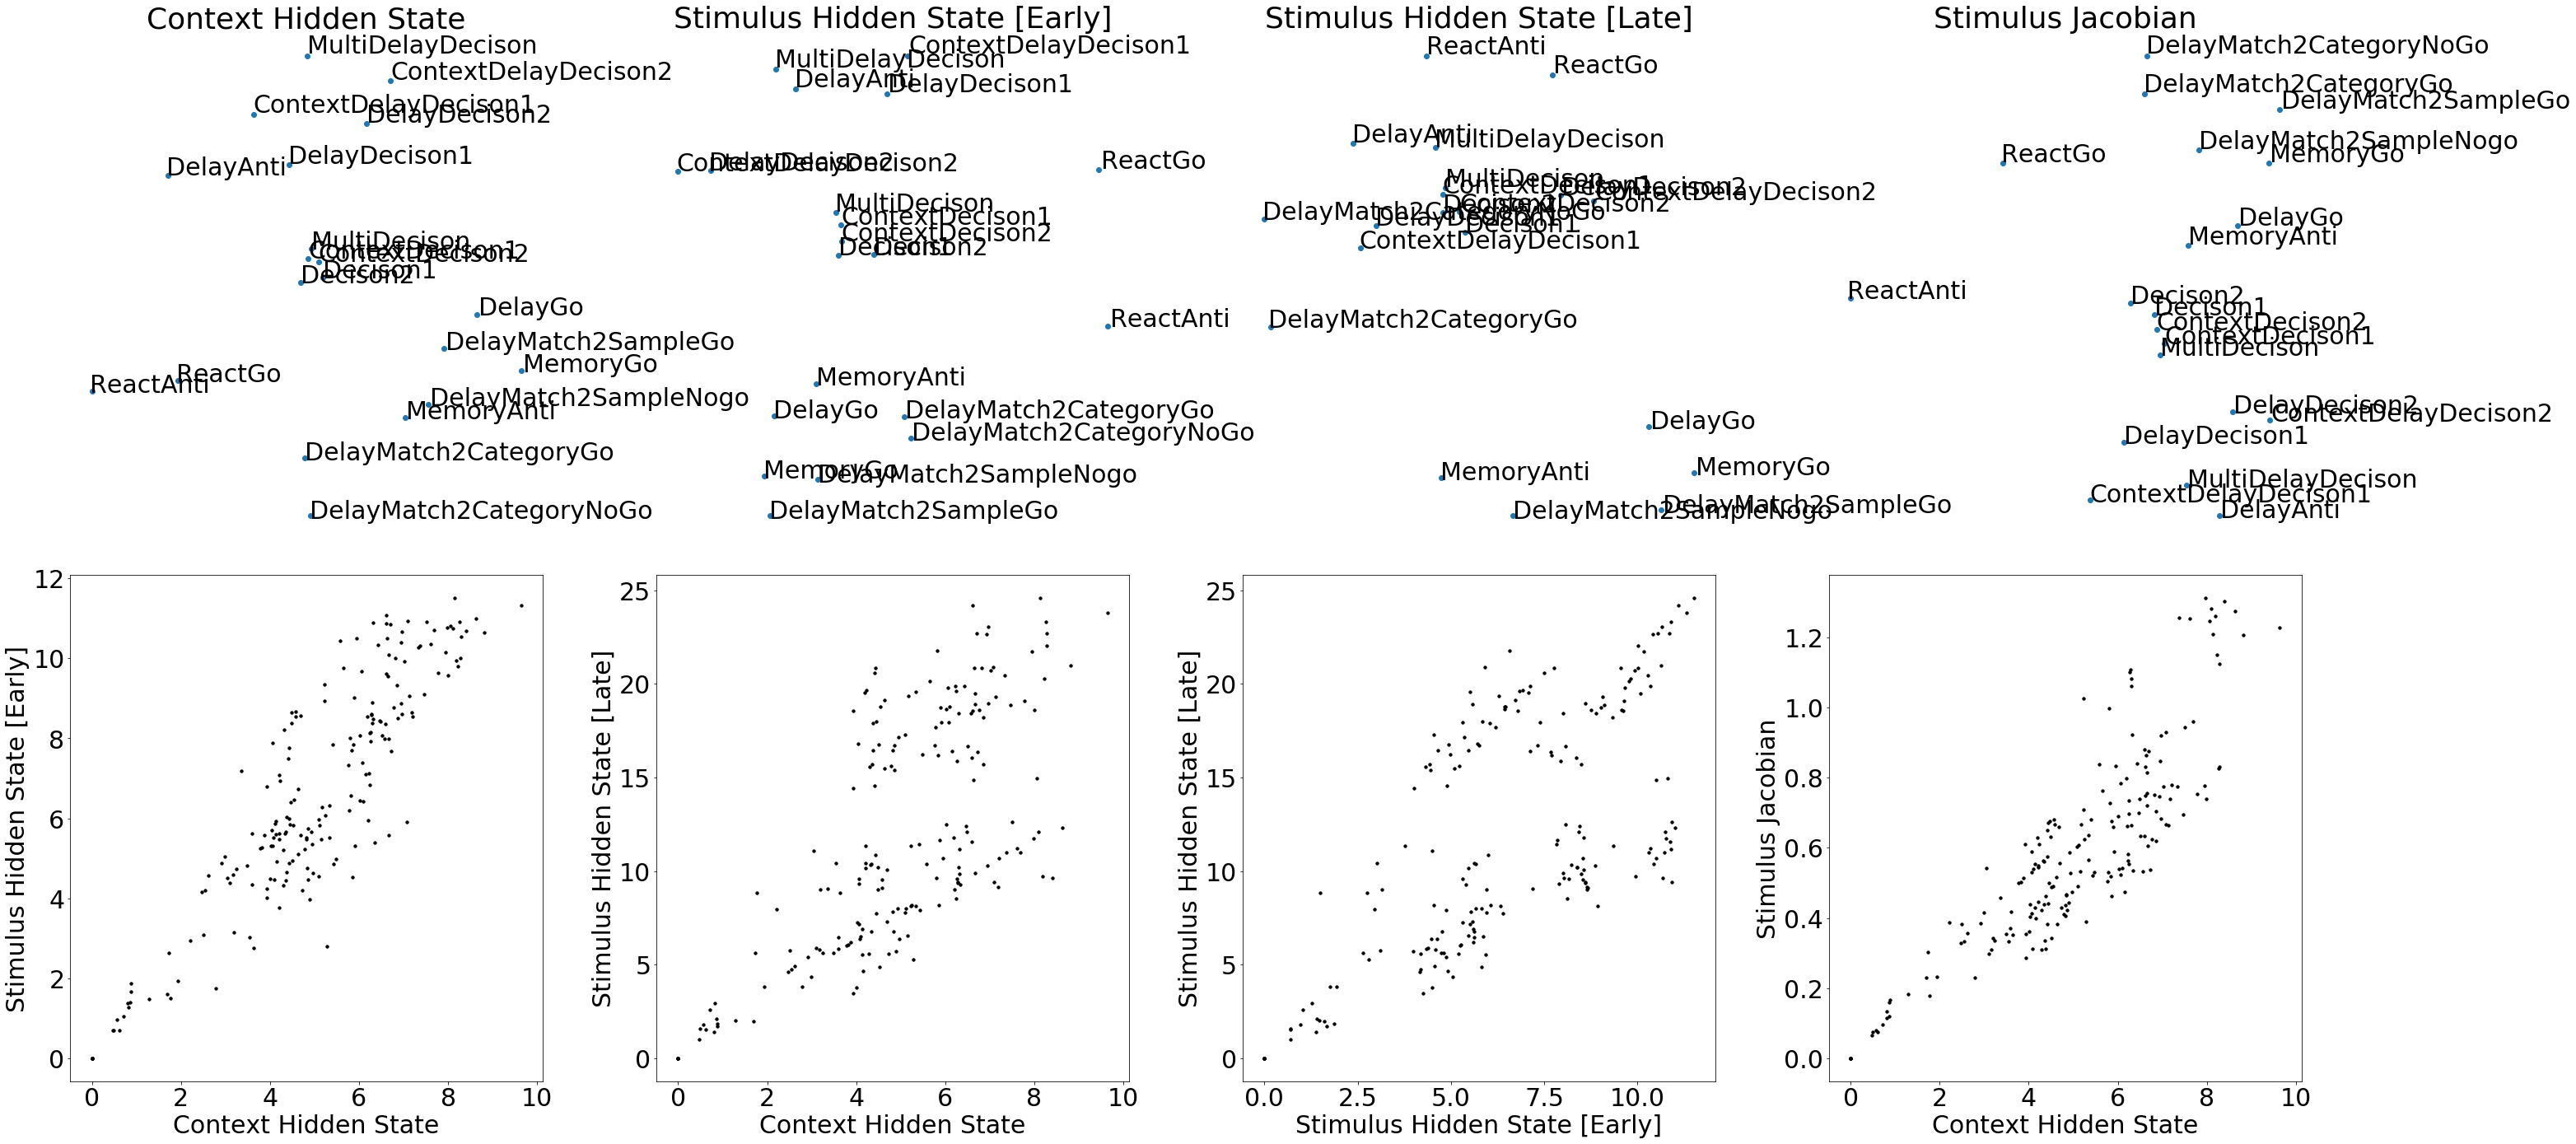

In [50]:
fig = plt.figure(figsize=(40, 20),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 30})

ax1 = plt.subplot(2,4,1)
plot_MDS_tasks(X_context)
plt.title('Context Hidden State')

ax2 = plt.subplot(2,4,2)
plot_MDS_tasks(X_del_stim_early)
plt.title('Stimulus Hidden State [Early]')

ax2 = plt.subplot(2,4,3)
plot_MDS_tasks(X_del_stim_late)
plt.title('Stimulus Hidden State [Late]')

ax2 = plt.subplot(2,4,4)
plot_MDS_tasks(X_stim_Jac)
plt.title('Stimulus Jacobian')

ax3 = plt.subplot(2,4,5)
plt.plot(X_euc_context[:],X_euc_stim_early[:],'.k')
plt.xlabel('Context Hidden State')
plt.ylabel('Stimulus Hidden State [Early]')

ax3 = plt.subplot(2,4,6)
plt.plot(X_euc_context[:],X_euc_stim_late[:],'.k')
plt.xlabel('Context Hidden State')
plt.ylabel('Stimulus Hidden State [Late]')

ax3 = plt.subplot(2,4,7)
plt.plot(X_euc_stim_early[:],X_euc_stim_late[:],'.k')
plt.xlabel('Stimulus Hidden State [Early]')
plt.ylabel('Stimulus Hidden State [Late]')

ax3 = plt.subplot(2,4,8)
plt.plot(X_euc_context[:],X_euc_stim_Jac[:],'.k')
plt.xlabel('Context Hidden State')
plt.ylabel('Stimulus Jacobian')

plt.show()

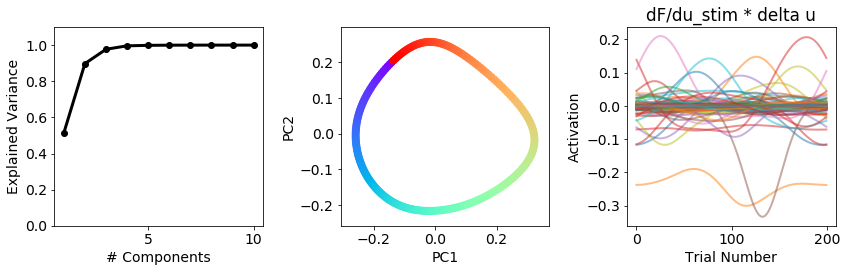

In [42]:
fig = plt.figure(figsize=(12, 4),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 14})

X = np.squeeze(J_np_u_dot_delu[2,:,0,:])

pca = PCA()
pca.fit(X)
X_pca = pca.fit_transform(X)
ev_all = pca.explained_variance_ratio_

ax1 = plt.subplot(1,3,1)
plt.plot(np.cumsum(ev_all[0:10]/sum(ev_all)),'-ok',linewidth = 3)
ax1.set_xlabel('# Components')
ax1.set_ylabel('Explained Variance')
ax1.set_ylim((0,1.1))
plt.xticks(np.arange(4, 10, step=5), np.arange(5, 11, step=5)) 

ax1 = plt.subplot(1,3,2)
plt.scatter(X_pca[:,0],X_pca[:,1],50,range(int(np.shape(X_pca)[0])),cmap = 'rainbow')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')

ax1 = plt.subplot(1,3,3)
plt.plot(X,linewidth = 2,alpha = .5)
plt.title('dF/du_stim * delta u')
plt.xlabel('Trial Number')
plt.ylabel('Activation')

plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /home/laura/data/rnn/multitask/crystals/softplus/no_reg/0/ckpts/model.ckpt-389000


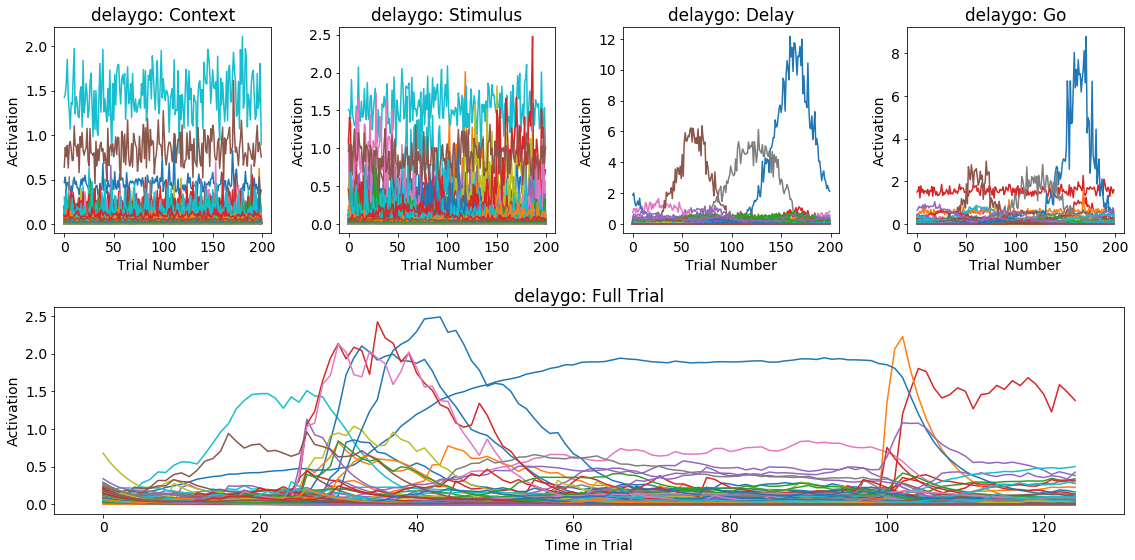

In [10]:
# Maybe useful [super basic] hidden unit activity visualization?
rule = 'delaygo'
model_n = 0
model = Model(model_dir_all)
with tf.Session() as sess:

    ckpt_n = name_best_ckpt(model_dir_all,'delaygo')
    ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))
    model.saver.restore(sess,ckpt_n_dir)
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials('delaygo', hparams, mode='test', noise_on=True, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        
fig = plt.figure(figsize=(16, 8),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 14})

ax1 = plt.subplot(2,4,1)
plt.plot(h_tf[trial.epochs['stim1'][0]-1,0:-1:2,:]) # Every other trial to exclude modality 2
plt.title(rule + ': Context')
plt.xlabel('Trial Number')
plt.ylabel('Activation')

ax1 = plt.subplot(2,4,2)
plt.plot(h_tf[trial.epochs['stim1'][0]+1,0:-1:2,:])
plt.title(rule + ': Stimulus')
plt.xlabel('Trial Number')
plt.ylabel('Activation')

ax1 = plt.subplot(2,4,3)
plt.plot(h_tf[trial.epochs['go1'][0]-1,0:-1:2,:])
plt.title(rule + ': Delay')
plt.xlabel('Trial Number')
plt.ylabel('Activation')

ax1 = plt.subplot(2,4,4)
plt.plot(h_tf[trial.epochs['go1'][0]+10,0:-1:2,:])
plt.title(rule + ': Go')
plt.xlabel('Trial Number')
plt.ylabel('Activation')

ax1 = plt.subplot(2,1,2)
plt.plot(h_tf[:,0,:])
plt.title(rule + ': Full Trial')
plt.xlabel('Time in Trial')
plt.ylabel('Activation')

plt.show()

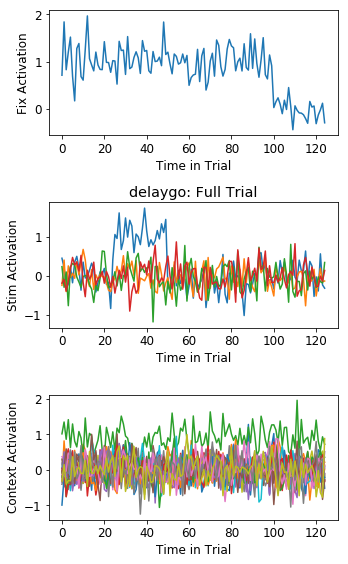

In [16]:
fig = plt.figure(figsize=(5, 8),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 12})
trial_n = 100

ax1 = plt.subplot(3,1,1)
plt.plot(trial.x[:,trial_n,0])
plt.xlabel('Time in Trial')
plt.ylabel('Fix Activation')

ax1 = plt.subplot(3,1,2)
plt.plot(trial.x[:,trial_n,1:5])
plt.title(rule + ': Full Trial')
plt.xlabel('Time in Trial')
plt.ylabel('Stim Activation')

ax1 = plt.subplot(3,1,3)
plt.plot(trial.x[:,trial_n,5:-1])
plt.xlabel('Time in Trial')
plt.ylabel('Context Activation')

plt.show()

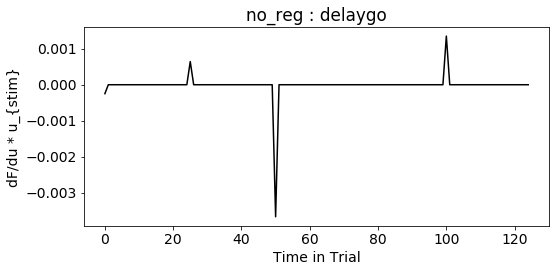

In [58]:
r = 2
fig = plt.figure(figsize=(8, 4),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 14})
plt.plot(np.mean(np.squeeze(J_np_u_dot_delu[r,0,:,:]),axis =1),'-k')
plt.title(dir_specific + ' : ' + rules_dict['all'][r])
plt.xlabel('Time in Trial')
plt.ylabel('dF/du * u_{stim}')
plt.savefig('sfn/gradients_dF/' + dir_specific + '/' + rules_dict['all'][r] + '_Jacs_alldu.svg')
plt.show()

Text(0,0.5,'PC2')

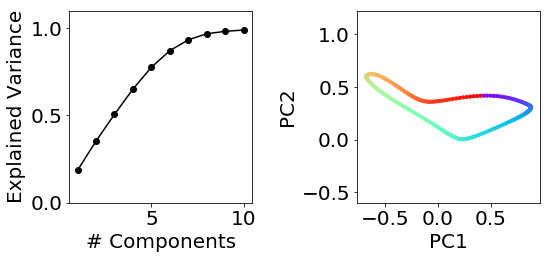

In [23]:
X = np.squeeze(J_np_u_dot_delu[r,0,0:-1:2,:])
# states = np.transpose(h_tf,(1,0,2))[:,in_set[ii],:]

pca = PCA()
X_pca = pca.fit_transform(X)#pca.transform(X)
ev_all = pca.explained_variance_ratio_


fig = plt.figure(figsize=(12, 4),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 20})

ax1 = plt.subplot(1,3,1)
plt.plot(np.cumsum(ev_all[0:10]/sum(ev_all)),'-ok')
ax1.set_xlabel('# Components')
ax1.set_ylabel('Explained Variance')
ax1.set_ylim((0,1.1))
plt.xticks(np.arange(4, 10, step=5), np.arange(5, 11, step=5)) 

ax1 = plt.subplot(1,3,2)
plt.scatter(X_pca[0:-1:2,0],X_pca[0:-1:2,1],10,range(int(np.shape(X_pca)[0]/2)),cmap = 'rainbow')
ax1.axis('equal')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')

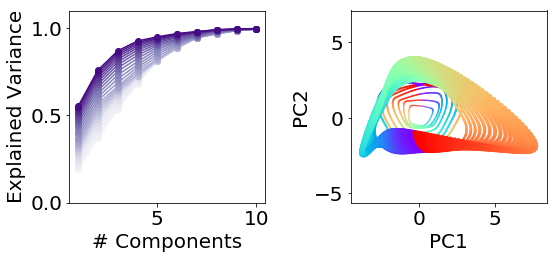

In [44]:
fig = plt.figure(figsize=(12, 4),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 20})
cmap=plt.get_cmap('Purples')

# X = np.squeeze(J_np_u_dot_u)
n_ts = 25

X = np.transpose(h_tf,(1,0,2))[:,in_set[ii]+1,:]
pca = PCA()
X_pca = pca.fit_transform(X)

for ts in range(n_ts):
    c = cmap(ts/n_ts)
    X = np.transpose(h_tf,(1,0,2))[:,in_set[ii]+ts,:]

#     pca = PCA()
    X_pca = pca.fit_transform(X)
    ev_all = pca.explained_variance_ratio_

    ax1 = plt.subplot(1,3,1)
    plt.plot(np.cumsum(ev_all[0:10]/sum(ev_all)),'-o',c=c)
    ax1.set_xlabel('# Components')
    ax1.set_ylabel('Explained Variance')
    ax1.set_ylim((0,1.1))
    plt.xticks(np.arange(4, 10, step=5), np.arange(5, 11, step=5)) 

    ax1 = plt.subplot(1,3,2)
    plt.scatter(X_pca[0:-1:2,0],X_pca[0:-1:2,1],ts**2/n_ts,range(int(np.shape(X_pca)[0]/2)),cmap = 'rainbow')
    ax1.axis('equal')
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')

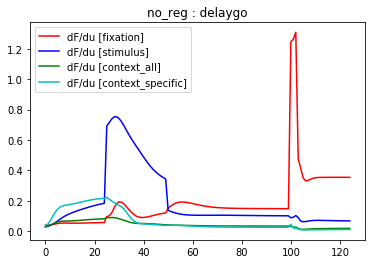

In [28]:
#     plt.plot(np.mean(LA.norm(J_np_x,axis=1),axis =1),'-k',label = 'dF/dx')
plt.plot(np.mean(LA.norm(J_np_u[:,:,:1],axis=1),axis =1),'-r',label = 'dF/du [fixation]')
plt.plot(np.mean(LA.norm(J_np_u[:,:,1:5],axis=1),axis =1),'-b',label = 'dF/du [stimulus]')
plt.plot(np.mean(LA.norm(J_np_u[:,:,5:],axis=1),axis =1),'-g',label = 'dF/du [context_all]')
plt.plot(np.mean(LA.norm(J_np_u[:,:,5+rule_n[0]:6+rule_n[0]],axis=1),axis =1),'-c',label = 'dF/du [context_specific]')
plt.title(dir_specific + ' : ' + rules_dict['all'][rule_n[0]])
plt.legend()
plt.savefig('sfn/gradients_dF/' + dir_specific + '/' + rules_dict['all'][rule_n[0]] + '_Jacs.svg')
plt.show()